In [1]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [63]:
# Data(x)
untreaded_train=np.load("../Classification/results2022/untreaded_train.npy",allow_pickle=True)[:500]
# untreaded_train=np.load("../Classification/results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("../Classification/results2022/VPAtreaded_train.npy",allow_pickle=True)[:500]
untreaded_test=np.load("../Classification/results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("../Classification/results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

# Label(y)
y_untreaded_train = torch.zeros(len(untreaded_train), dtype=torch.int64)
y_VPAtreaded_train = torch.ones(len(VPAtreaded_train), dtype=torch.int64)
y_untreaded_test = torch.zeros(len(untreaded_test), dtype=torch.int64)
y_VPAtreaded_test = torch.ones(len(VPAtreaded_test), dtype=torch.int64)

# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = torch.cat((y_untreaded_train, y_VPAtreaded_train), 0), torch.cat((y_untreaded_test, y_VPAtreaded_test), 0)

untreaded_train.shape: (500, 100, 100, 3)
VPAtreaded_train.shape: (500, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


# 2. Data processing 

In [64]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

# trainval_data = cell_dataset(X_train, y_train)
train_data = cell_dataset(X_train, y_train)
val_data = cell_dataset(X_test, y_test)

batch_size = 32
# val_size = int(len(trainval_data)*0.2)
# train_size = len(trainval_data) - val_size

# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

# 3. Build Model

## 3.1.0 UNet model

In [114]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample00 = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        self.up_sample01 = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=3, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    def forward(self, down_input, skip_input):
        if skip_input.shape[2]%2==0:
            x = self.up_sample00(down_input)
        else:
            x = self.up_sample01(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [115]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(64 + 128, 64)
        # output
        self.output = nn.Conv2d(64,3,kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_image):
        x, skip1_out = self.down_conv1(input_image)
        thre = (input_image>0).float()
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

## 3.1.1 UNetblock

In [116]:
class UNetblock(nn.Module):
    def __init__(self):
        super(UNetblock,self).__init__()
        self.UNet = UNet()
        self.UNet.load_state_dict(torch.load("UNet_one_3C_weight.pkl"))
        
    def forward(self, x):
        x = self.UNet(x)
        return x

## 3.2 Maskblock

In [117]:
class Maskblock(nn.Module):
    def __init__(self):
        super(Maskblock,self).__init__()
#         self.mask_block = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=3, padding=1),
#             nn.BatchNorm2d(8),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(8, 3, kernel_size=3, padding=1),
#             nn.BatchNorm2d(3),
#             nn.ReLU(inplace=True),
#         )
#         self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
#         x = self.mask_block(x)
#         x = self.relu(x)
#         x = self.sigmoid(x)
        return x

## 3.3 ResNetblock

In [118]:
class ResNetblock(nn.Module):
    def __init__(self):
        super(ResNetblock,self).__init__()
        self.resnet = models.resnet18(weights=True)
        self.resnet.layer3 = nn.Sequential()
        self.resnet.layer4 = nn.Sequential()
        self.resnet.fc = nn.Linear(128, 2)
#         self.resnet.load_state_dict(torch.load(""))
#         self.resnet = torch.load("../Classification/model/SelfResnet9C1F_220920.pkl")
        
    def forward(self, x):
        x = self.resnet(x)
        x = nn.Softmax(dim=1)(x)
        return x

## 3.9 MaskUNet

In [119]:
class maskUNet(nn.Module):
    def __init__(self):
        super(maskUNet, self).__init__()
        self.UNetblock = UNetblock()
        self.Maskblock = Maskblock()
        self.ResNetblock = ResNetblock()
        
    def forward(self, input_image):
        # UNet
        mask = self.UNetblock(input_image)
        # Mask
#         mask = self.Maskblock(mask)
#         mask = torch.cat((mask, mask, mask), 1)
        # ResNet
        masked_image = torch.multiply(mask, input_image)
        output = self.ResNetblock(masked_image)
        return mask, output

In [120]:
model = maskUNet().to(device)

## 3.3 Param setting

In [121]:
# >> Freeze UNet weights
# for param in model.UNetblock.UNet.down_conv1.parameters():
#     param.requires_grad = False
# for param in model.UNetblock.UNet.down_conv2.parameters():
#     param.requires_grad = False
# for param in model.UNetblock.UNet.down_conv3.parameters():
#     param.requires_grad = False
# for param in model.UNetblock.UNet.down_conv4.parameters():
#     param.requires_grad = False
# for param in model.UNetblock.UNet.double_conv.parameters():
#     param.requires_grad = False

# >> Freeze ResNet weights
# for param in model.ResNetblock.resnet.parameters():
#     param.requires_grad = False
# for param in model.ResNetblock.resnet.fc.parameters():
#     param.requires_grad = True

In [122]:
ngpu = 4
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

## 3.4 Loss

In [123]:
class mask_Loss(nn.Module):
    def __init__(self):
        super(mask_Loss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')

    def forward(self, mask, input_image): 
        bin_image = (input_image==0).float()
        allzero = torch.zeros(bin_image.shape).to(device)
        mask = torch.multiply(mask, bin_image)
        return self.mse_loss(allzero, mask).sum()

In [124]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
criterion_mask = mask_Loss()
criterion_label = nn.BCELoss()
# criterion_label = nn.CrossEntropyLoss()

# 0.0 demo test

 mask loss:  tensor(17947.3770, device='cuda:0', grad_fn=<SumBackward0>)
label loss:  tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
predict y:  tensor([[0.5784, 0.4216]], device='cuda:0', grad_fn=<GatherBackward>)


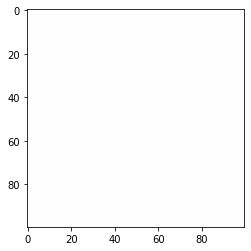

In [125]:
image_num = 1
test_input = train_data[image_num][0].unsqueeze(0).to(device)
mask, y = model(test_input)
print(" mask loss: ", criterion_mask(mask, test_input))
print("label loss: ", criterion_label(y, train_data[image_num][1].unsqueeze(0).to(device)))

print("predict y: ",y)
plt.imshow(mask[0].detach().cpu().permute(1,2,0))

# 4. Train

In [126]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

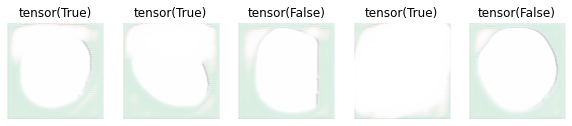

EPOCH: 0, Train [Loss_mask: 562281.127, Loss_label: 0.531, Accuracy: 0.738], Valid [Loss: 0.542, Accuracy: 0.786]
EPOCH: 1, Train [Loss_mask: 470496.021, Loss_label: 0.473, Accuracy: 0.765], Valid [Loss: 0.512, Accuracy: 0.721]
EPOCH: 2, Train [Loss_mask: 333882.971, Loss_label: 0.454, Accuracy: 0.785], Valid [Loss: 0.423, Accuracy: 0.819]
EPOCH: 3, Train [Loss_mask: 400394.050, Loss_label: 0.443, Accuracy: 0.790], Valid [Loss: 0.371, Accuracy: 0.824]
EPOCH: 4, Train [Loss_mask: 397097.958, Loss_label: 0.456, Accuracy: 0.795], Valid [Loss: 0.769, Accuracy: 0.567]
EPOCH: 5, Train [Loss_mask: 419438.822, Loss_label: 0.413, Accuracy: 0.816], Valid [Loss: 0.413, Accuracy: 0.819]
EPOCH: 6, Train [Loss_mask: 521439.774, Loss_label: 0.400, Accuracy: 0.821], Valid [Loss: 0.542, Accuracy: 0.752]
EPOCH: 7, Train [Loss_mask: 529331.843, Loss_label: 0.465, Accuracy: 0.792], Valid [Loss: 0.415, Accuracy: 0.843]
EPOCH: 8, Train [Loss_mask: 520523.741, Loss_label: 0.407, Accuracy: 0.812], Valid [Loss

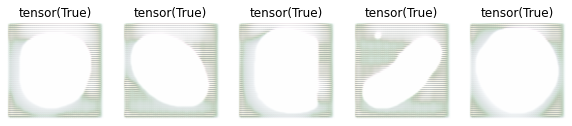

EPOCH: 10, Train [Loss_mask: 456121.028, Loss_label: 0.382, Accuracy: 0.822], Valid [Loss: 0.415, Accuracy: 0.812]
EPOCH: 11, Train [Loss_mask: 444797.792, Loss_label: 0.397, Accuracy: 0.827], Valid [Loss: 0.334, Accuracy: 0.840]
EPOCH: 12, Train [Loss_mask: 446622.554, Loss_label: 0.342, Accuracy: 0.843], Valid [Loss: 0.478, Accuracy: 0.760]
EPOCH: 13, Train [Loss_mask: 453041.214, Loss_label: 0.344, Accuracy: 0.844], Valid [Loss: 0.534, Accuracy: 0.757]
EPOCH: 14, Train [Loss_mask: 464372.788, Loss_label: 0.324, Accuracy: 0.860], Valid [Loss: 0.367, Accuracy: 0.836]
EPOCH: 15, Train [Loss_mask: 452473.946, Loss_label: 0.369, Accuracy: 0.836], Valid [Loss: 0.585, Accuracy: 0.755]
EPOCH: 16, Train [Loss_mask: 414521.649, Loss_label: 0.397, Accuracy: 0.825], Valid [Loss: 0.565, Accuracy: 0.693]
EPOCH: 17, Train [Loss_mask: 406113.745, Loss_label: 0.363, Accuracy: 0.840], Valid [Loss: 0.380, Accuracy: 0.840]
EPOCH: 18, Train [Loss_mask: 348167.123, Loss_label: 0.348, Accuracy: 0.845], Va

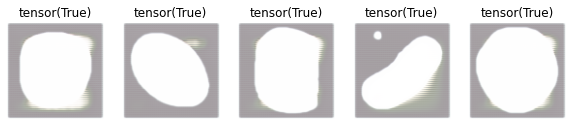

EPOCH: 20, Train [Loss_mask: 333432.999, Loss_label: 0.298, Accuracy: 0.876], Valid [Loss: 0.459, Accuracy: 0.783]
EPOCH: 21, Train [Loss_mask: 371679.401, Loss_label: 0.259, Accuracy: 0.892], Valid [Loss: 0.456, Accuracy: 0.802]
EPOCH: 22, Train [Loss_mask: 391147.197, Loss_label: 0.258, Accuracy: 0.902], Valid [Loss: 0.668, Accuracy: 0.721]
EPOCH: 23, Train [Loss_mask: 399937.116, Loss_label: 0.247, Accuracy: 0.898], Valid [Loss: 0.407, Accuracy: 0.817]
EPOCH: 24, Train [Loss_mask: 286511.647, Loss_label: 0.301, Accuracy: 0.878], Valid [Loss: 0.545, Accuracy: 0.736]
EPOCH: 25, Train [Loss_mask: 306540.571, Loss_label: 0.345, Accuracy: 0.848], Valid [Loss: 0.419, Accuracy: 0.824]
EPOCH: 26, Train [Loss_mask: 336556.156, Loss_label: 0.244, Accuracy: 0.913], Valid [Loss: 0.449, Accuracy: 0.795]
EPOCH: 27, Train [Loss_mask: 571936.538, Loss_label: 0.347, Accuracy: 0.845], Valid [Loss: 0.363, Accuracy: 0.867]
EPOCH: 28, Train [Loss_mask: 583102.359, Loss_label: 0.282, Accuracy: 0.880], Va

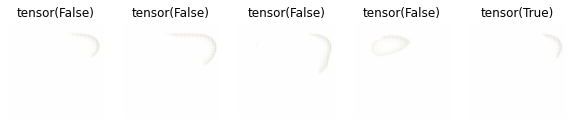

EPOCH: 30, Train [Loss_mask: 587561.915, Loss_label: 0.212, Accuracy: 0.921], Valid [Loss: 0.760, Accuracy: 0.721]
EPOCH: 31, Train [Loss_mask: 589232.590, Loss_label: 0.201, Accuracy: 0.921], Valid [Loss: 0.458, Accuracy: 0.812]
EPOCH: 32, Train [Loss_mask: 589473.111, Loss_label: 0.188, Accuracy: 0.934], Valid [Loss: 0.401, Accuracy: 0.845]
EPOCH: 33, Train [Loss_mask: 588802.699, Loss_label: 0.205, Accuracy: 0.923], Valid [Loss: 0.601, Accuracy: 0.819]
EPOCH: 34, Train [Loss_mask: 587185.262, Loss_label: 0.154, Accuracy: 0.946], Valid [Loss: 0.494, Accuracy: 0.805]
EPOCH: 35, Train [Loss_mask: 587875.838, Loss_label: 0.240, Accuracy: 0.914], Valid [Loss: 0.437, Accuracy: 0.845]
EPOCH: 36, Train [Loss_mask: 587484.512, Loss_label: 0.222, Accuracy: 0.920], Valid [Loss: 0.480, Accuracy: 0.812]
EPOCH: 37, Train [Loss_mask: 587102.473, Loss_label: 0.181, Accuracy: 0.937], Valid [Loss: 0.567, Accuracy: 0.795]
EPOCH: 38, Train [Loss_mask: 587042.905, Loss_label: 0.157, Accuracy: 0.947], Va

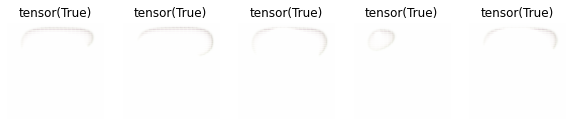

EPOCH: 40, Train [Loss_mask: 586852.667, Loss_label: 0.162, Accuracy: 0.938], Valid [Loss: 0.478, Accuracy: 0.805]
EPOCH: 41, Train [Loss_mask: 587447.501, Loss_label: 0.114, Accuracy: 0.959], Valid [Loss: 1.069, Accuracy: 0.688]


KeyboardInterrupt: 

In [127]:
n_epochs = 100
for epoch in range(n_epochs):
    losses_train = []
    losses_mask = []
    losses_label = []
    losses_valid = []
    
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()
        x = x.to(device)
        y = y.to(device)
        mask, output = model.forward(x)
        
        loss_mask = criterion_mask(mask, x)
        loss_label = criterion_label(output, y)
        loss = loss_label
        loss.backward()
        optimizer.step()
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
        losses_mask.append(loss_mask.tolist())
        losses_label.append(loss_label.tolist())

    # Evaluate
    model.eval()
    if epoch%10==0:
        plt.figure(figsize=(10,10))
        for i in range(5):
            img = train_data[i][0].permute(1,2,0).numpy()
            label = train_data[i][1][1]
            input_tensor = train_data[i][0].unsqueeze(0).to(device)
            mask, output = model(input_tensor)
            y = output.argmax(1).cpu().item()
            mask = mask[0].detach().cpu().permute(1,2,0)
            plt.subplot(1,5,i+1)
            plt.axis('off')
            plt.title(str(y==label))
            plt.imshow(mask)
        plt.show()
        
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)
        y = y.to(device)
        mask,output = model.forward(x)
        loss = criterion_label(output, y)
        pred = output.argmax(1)
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss_mask: {:.3f}, Loss_label: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_mask),np.mean(losses_label),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

In [ ]:
# train processing plot
n_epochs = 100
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. Mask

In [128]:
i = 1
img = train_data[i][0].permute(1,2,0).numpy()
label = train_data[i][1][1]
input_tensor = train_data[i][0].unsqueeze(0).to(device)
mask, output = model(input_tensor)
y = output.argmax(1).cpu().item()
print("y is",y , "; pre is", label.item(), "=>",y==label.item())

y is 0 ; pre is 0.0 => True


max: 1.000, min: 0.839


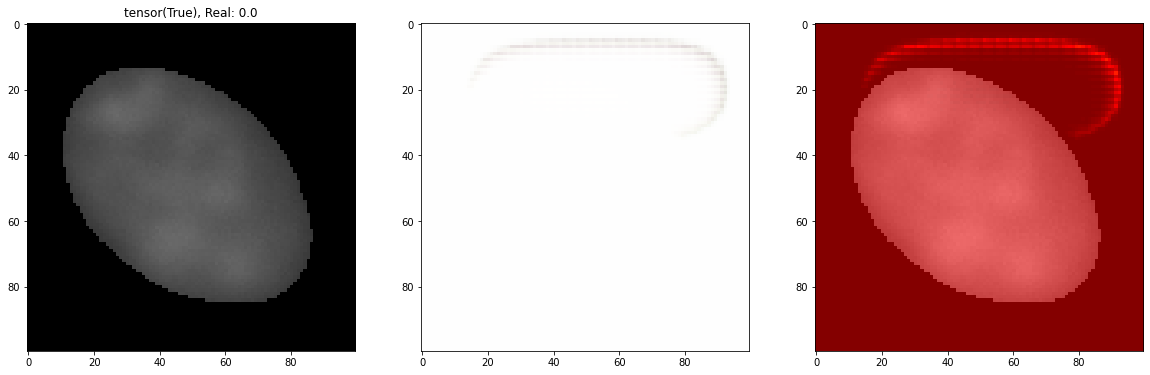

In [129]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title(str(y==label)+", Real: "+str(label.item()))
plt.imshow(img)

mask = mask[0].detach().cpu().permute(1,2,0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(mask),torch.amin(mask)))
plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
cam = show_cam_on_image(img, mask, True)
plt.imshow(cam)

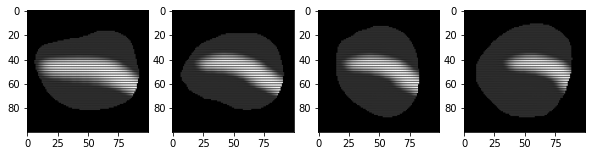

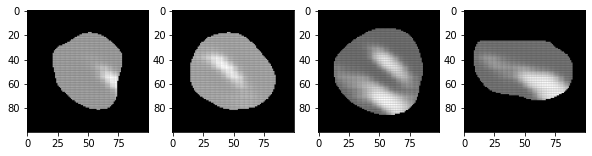

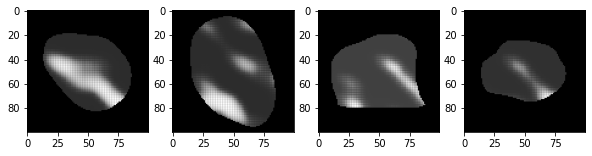

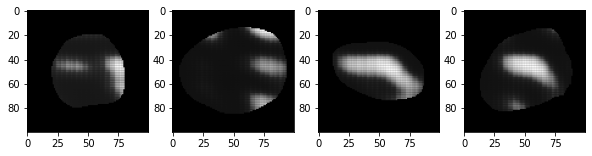

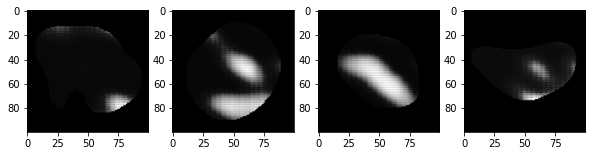

In [45]:
for j in range(len(masklist)):
    plt.figure(figsize=(10,10))
    for i in range(masklist[j].shape[0]):
        mask = masklist[j][i].permute(1,2,0).cpu().detach().numpy()
        plt.subplot(1,4,i+1)
        plt.imshow(mask/np.amax(mask))

# 5. Feature map

In [65]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
    print(name)


pre_layer
pre_layer.0
pre_layer.1
pre_layer.2
residual_layer
residual_layer.0
residual_layer.0.residualblock
residual_layer.0.residualblock.0
residual_layer.0.residualblock.1
residual_layer.0.residualblock.2
residual_layer.0.residualblock.3
residual_layer.0.residualblock.4
residual_layer.0.residualblock.5
residual_layer.0.residualblock.6
residual_layer.0.residualblock.7
residual_layer.1
residual_layer.1.residualblock
residual_layer.1.residualblock.0
residual_layer.1.residualblock.1
residual_layer.1.residualblock.2
residual_layer.1.residualblock.3
residual_layer.1.residualblock.4
residual_layer.1.residualblock.5
residual_layer.1.residualblock.6
residual_layer.1.residualblock.7
residual_layer.2
residual_layer.2.residualblock
residual_layer.2.residualblock.0
residual_layer.2.residualblock.1
residual_layer.2.residualblock.2
residual_layer.2.residualblock.3
residual_layer.2.residualblock.4
residual_layer.2.residualblock.5
residual_layer.2.residualblock.6
residual_layer.2.residualblock.7
ma

In [79]:
# for name, layer in model.named_modules():
#     bn = feature_activation[name].cpu()[0]
#     print('max: {:.3f}, min: {:.3f}'.format(torch.amax(bn),torch.amin(bn)))
#     if bn.shape[0]==10000:
#         bn = bn.reshape(100,100)
#         plt.title(name)
#         plt.imshow(bn)
#         plt.show()

max: 15.391, min: 0.000


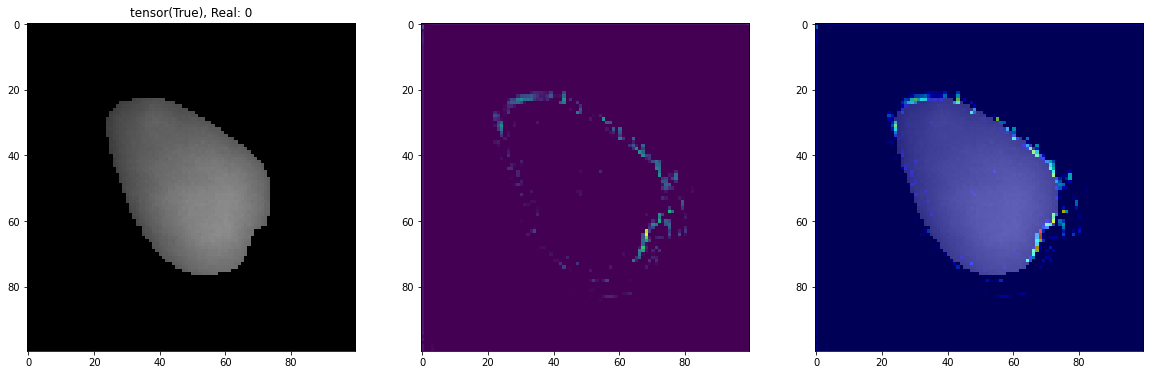

In [80]:
key = "mask_layer"
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title(str(y==label)+", Real: "+str(label.item()))
plt.imshow(img)

mask = feature_activation[key].cpu()[0].mean(axis=0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(mask),torch.amin(mask)))
mask = cv2.normalize(mask.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
cam = show_cam_on_image(img, mask, True)
plt.imshow(cam)

In [146]:
# num = feature_activation[key].cpu()[0].shape[0]
# num = 10
# for i in range(num):
#     plt.figure(figsize=(10,10))
#     plt.subplot(1,3,1)
#     plt.title(y==label)
#     plt.imshow(img/np.amax(img))
    
#     bn = feature_activation[key].cpu()[0][i]
#     bn = cv2.normalize(bn.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
#     plt.subplot(1,3,2)
#     plt.title(key)
#     plt.imshow(bn)
    
#     plt.subplot(1,3,3)
#     plt.axis("off")
#     bn = cv2.merge([bn,bn,bn])
#     cam = show_cam_on_image(img, bn)
#     plt.imshow(cam)

In [62]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

pre_layer.0  :  torch.Size([1, 64, 100, 100])
pre_layer.1  :  torch.Size([1, 64, 100, 100])
pre_layer.2  :  torch.Size([1, 64, 100, 100])
pre_layer  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.2  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.3  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.4  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.5  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.6  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.7  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock  :  torch.Size([1, 64, 100, 100])
residual_layer.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.2

# 5. GradCAM

In [128]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor,targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
#     if np.amax(gb)!=0:
#         gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

tensor(True)


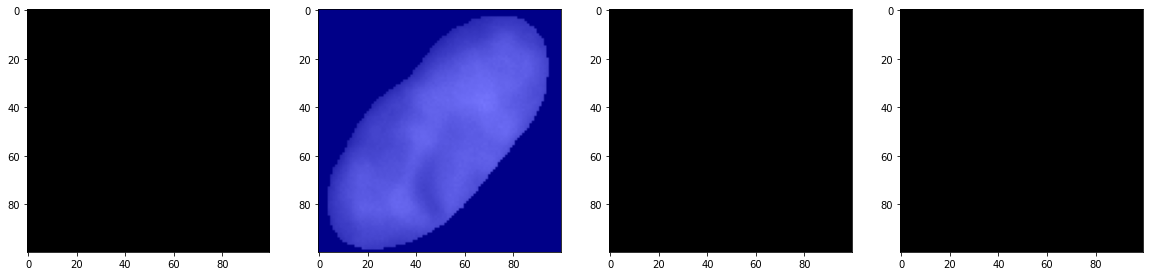

In [203]:
target_layers = [model.last_layer[0]]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
print(y==label)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(cam)
plt.subplot(1,4,2)
plt.imshow(visualization)
plt.subplot(1,4,3)
plt.imshow(gb)
plt.subplot(1,4,4)
plt.imshow(cam_gb)

# 99. save model

In [59]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.state_dict(),"maskUNet.pkl")